# K-Nearest Neighbors Model

### Imports

In [243]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import shap
import xgboost as xgb
import sklearn

## Import data and identify catagorical varables

In [244]:
raw_data = pd.read_csv('../../normalized_data.csv')
#raw_data = pd.read_csv('../../rodpump_noImputed.csv')

In [245]:
categorical_columns = ['bha_configuration',
                      'wellbore_category',
                       'packer_vs_tac',
                       'rod_sinker_type',
                       'manual_scale',
                       'rod_make',
                       'rod_apigrade',
                       'DESANDDEGAS_TYP',
                       'rod_has_guides',
                       'pump_bore'
                      ]

## Encode catagorical variables

In [246]:
def encode(df, columns):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df

In [247]:
for column in raw_data:
    if (column in categorical_columns):
        encode(raw_data, column)

## Creating and normalizing test-train data

In [248]:
features = list(raw_data)
features.remove('FAILURETYPE')
features.remove('roduid')
features.remove('UWI')
#remove lifetime_end only for rodpump_noImputed dataset
#features.remove('lifetime_end')
features.remove('pump_bore')
features.remove('contains_imputed')

#define x and y dataset (train/ test data)
X = raw_data[features]
y = raw_data['FAILURETYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)

#scaling/normalizing
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)




## Finding best K value to use for model

In [249]:
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

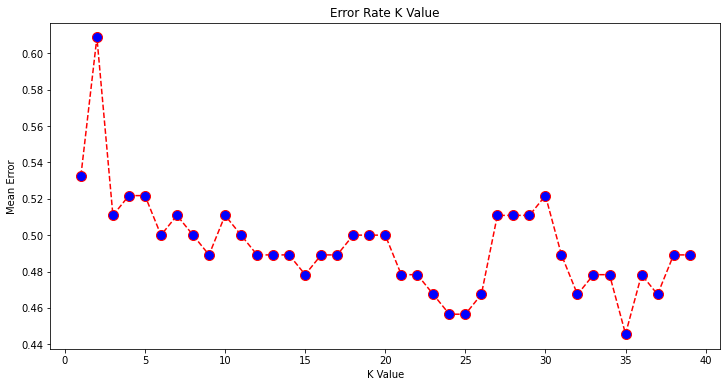

In [250]:

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

## Training the model and finding the accuracy with the best K-value

In [251]:
best_k = 0
best_metric = 0
for i in range(1, 40):
    n_neighbors=i
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    
    if metrics.accuracy_score(y_test, pred_i) > best_metric:
        best_k = n_neighbors
        best_metric =  metrics.accuracy_score(y_test, pred_i)
       

In [252]:
knn = KNeighborsClassifier(best_k)
knn.fit(X_train, y_train)
pred_i = knn.predict(X_test)
confus_matrix = confusion_matrix(y_test, pred_i)
print(confus_matrix)
print(classification_report(y_test, pred_i))

[[22  5  4]
 [ 7 16  6]
 [ 8 11 13]]
                 precision    recall  f1-score   support

           Rods       0.59      0.71      0.65        31
Sucker Rod Pump       0.50      0.55      0.52        29
         Tubing       0.57      0.41      0.47        32

       accuracy                           0.55        92
      macro avg       0.55      0.56      0.55        92
   weighted avg       0.55      0.55      0.55        92



- Accuracy = # of correct predictions over total predictions
- Precision = # correctly positively identified classifiactions over total positive identifications (True positives  over True positives + False Positives)
- Recall = # of actual postives identified correctly (True positives over true positives + false negatives), want this to generally be close to 1.00
- F1-score = the harmonic mean of precision and recall, preciseness of model
- Support = total number test cases

## Confusion Matrix and Accuracy Score

The best accuracy of the KNN model unsing a K value of 35 is: 0.5543478260869565


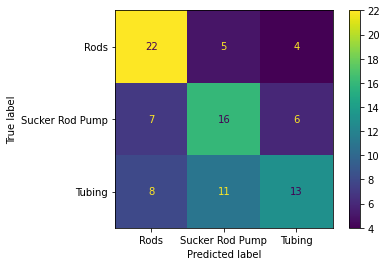

In [253]:
plot_confusion_matrix(knn, X_test, y_test)
print("The best accuracy of the KNN model unsing a K value of " + str(best_k) +" is: " + str(best_metric))

Cross Validation Score: 0.48363774733637743


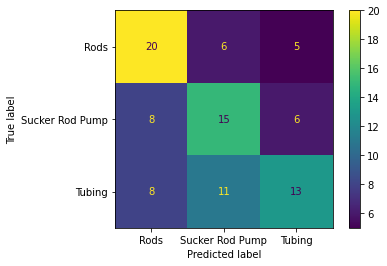

In [254]:
#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 40)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
knn_gscv.best_params_

#confusion matrix
plot_confusion_matrix(knn_gscv,X_test,y_test)

#check mean score for the top performing value of n_neighbors
print("Cross Validation Score: " + str(knn_gscv.best_score_))

In [255]:
shap.initjs()

X = raw_data[features]
encode(raw_data, 'FAILURETYPE')
y = raw_data['FAILURETYPE']
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=7)

dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
for k,dtype in dtypes:
    m = X_train[k].mean()
    s = X_train[k].std()
    X_train_norm[k] -= m
    X_train_norm[k] /= s

    X_valid_norm[k] -= m
    X_valid_norm[k] /= s

knn_norm = sklearn.neighbors.KNeighborsClassifier()
knn_norm.fit(X_train_norm, y_train)

f = lambda x: knn_norm.predict_proba(x)[:,1]
med = X_train_norm.median().values.reshape((1,X_train_norm.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values_norm = explainer.shap_values(X_valid_norm.iloc[0:1000,:], nsamples=1000)
shap.force_plot(explainer.expected_value, shap_values_norm, X_valid.iloc[0:1000,:])

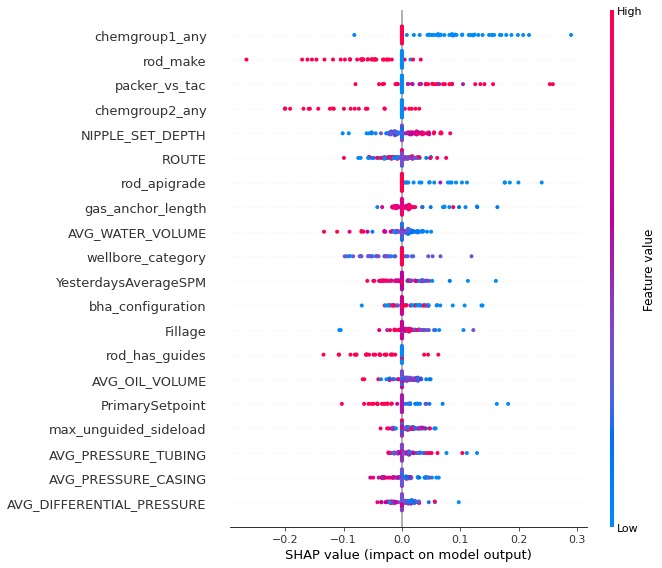

In [257]:
shap.summary_plot(shap_values_norm, X_valid.iloc[0:1000,:])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


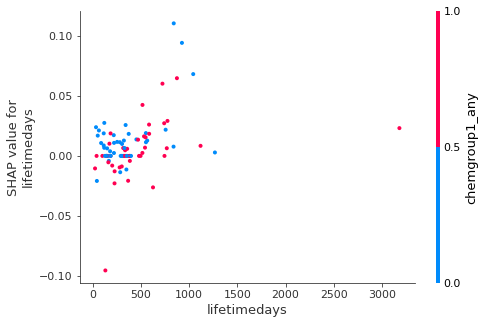

In [258]:
shap.dependence_plot("lifetimedays", shap_values_norm, X_valid.iloc[0:1000,:])